In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [51]:
%pip install mlflow
%pip install dagshub

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import time
import warnings
import gc
import mlflow
import mlflow.sklearn
import os
import dagshub

In [53]:
# Start timer
start_time = time.time()

# Initialize MLflow tracking
mlflow_active = False
try:
    # Initialize Dagshub
    dagshub.init(repo_owner='konstantine25b', repo_name='IEEE-CIS-Fraud-Detection', mlflow=True)
    print("DagsHub initialized successfully.")
    mlflow.set_experiment("IEEE-CIS Fraud Detection_XGBoost_New_Preprocessing")
    print(f"MLflow experiment set to: {mlflow.get_experiment_by_name('IEEE-CIS Fraud Detection_XGBoost_New_Preprocessing').name}")
    mlflow_active = True
except Exception as e:
    print(f"Could not initialize DagsHub or set MLflow experiment: {e}")
    print("Proceeding without MLflow tracking.")


Initialized MLflow to track repo "konstantine25b/IEEE-CIS-Fraud-Detection"

Repository konstantine25b/IEEE-CIS-Fraud-Detection initialized!

DagsHub initialized successfully.
MLflow experiment set to: IEEE-CIS Fraud Detection_XGBoost_New_Preprocessing


In [54]:
# Start MLflow run
run_name = f"xgboost_preprocessing_{time.strftime('%Y%m%d_%H%M%S')}"
if mlflow_active:
    try:
        mlflow.start_run(run_name=run_name)
        print(f"MLflow run started with name: {run_name}")
    except Exception as e:
        print(f"Could not start MLflow run: {e}")
        mlflow_active = False


MLflow run started with name: xgboost_preprocessing_20250421_101352


# Loading Data

In [55]:
print("\n--- Loading Original Data from Kaggle ---")
try:
    identity_df = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
    transaction_df = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
    print(f"Loaded identity data shape: {identity_df.shape}")
    print(f"Loaded transaction data shape: {transaction_df.shape}")
    
    if mlflow_active:
        try:
            mlflow.log_param("identity_data_shape", str(identity_df.shape))
            mlflow.log_param("transaction_data_shape", str(transaction_df.shape))
        except Exception as e:
            print(f"Warning: Could not log data shapes to MLflow: {e}")
except FileNotFoundError:
    print("Error: One or both of the CSV files were not found. Please make sure the file paths are correct.")
    if mlflow_active:
        mlflow.end_run()
    exit()


--- Loading Original Data from Kaggle ---
Loaded identity data shape: (144233, 41)
Loaded transaction data shape: (590540, 394)


# Preprocessing

In [56]:

class HighNullDropper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold
        self.columns_to_drop = None
    
    def fit(self, X, y=None):
        # Calculate null percentage for each column
        null_percentage = X.isnull().mean() * 100
        
        # Identify columns to drop
        self.columns_to_drop = null_percentage[null_percentage >= self.threshold].index.tolist()
        print(f"Identified {len(self.columns_to_drop)} columns with ≥{self.threshold}% nulls")
        
        return self
    
    def transform(self, X):
        if self.columns_to_drop:
            X_transformed = X.drop(columns=self.columns_to_drop)
            print(f"Dropped {len(self.columns_to_drop)} high-null columns. New shape: {X_transformed.shape}")
            return X_transformed
        return X

In [57]:
class WoEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, smoothing=0.5):
        self.smoothing = smoothing
        self.woe_maps = {}
        self.default_values = {}
    
    def fit(self, X, y):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        for col in X.columns:
            # Calculate WoE for each category
            woe_map = {}
            total_pos = y.sum()
            total_neg = len(y) - total_pos
            
            # Group by category and calculate counts
            grouped = pd.DataFrame({'target': y, 'feature': X[col]}).groupby('feature')
            counts = grouped.size()
            pos_counts = grouped['target'].sum()
            
            # Calculate WoE for each category
            for category, count in counts.items():
                if pd.isna(category):
                    continue
                
                pos = pos_counts.get(category, 0)
                neg = count - pos
                
                # Apply smoothing
                pos_rate = (pos + self.smoothing) / (total_pos + self.smoothing * len(counts))
                neg_rate = (neg + self.smoothing) / (total_neg + self.smoothing * len(counts))
                
                # Calculate WoE
                if neg_rate > 0 and pos_rate > 0:
                    woe = np.log(pos_rate / neg_rate)
                else:
                    woe = 0
                
                woe_map[category] = woe
            
            # Store WoE mapping for this column
            self.woe_maps[col] = woe_map
            
            # Calculate default value (weighted average)
            if woe_map:
                self.default_values[col] = sum(woe_map.values()) / len(woe_map)
            else:
                self.default_values[col] = 0
        
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        X_woe = X.copy()
        
        for col in X.columns:
            if col in self.woe_maps:
                # Replace each category with its WoE value
                woe_map = self.woe_maps[col]
                default_value = self.default_values[col]
                
                # Apply WoE mapping with default for unseen categories
                X_woe[col] = X_woe[col].map(lambda x: woe_map.get(x, default_value))
        
        return X_woe

In [58]:
class IdentityFlagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.transactions_with_identity = None
    
    def fit(self, X, identity_df, y=None):
        # Get TransactionIDs with identity information
        self.transactions_with_identity = set(identity_df['TransactionID'].unique())
        return self
    
    def transform(self, X):
        # Add identity flag
        X_copy = X.copy()
        X_copy['has_identity'] = X_copy['TransactionID'].isin(self.transactions_with_identity).astype(int)
        print(f"Added has_identity flag. Transactions with identity: {X_copy['has_identity'].sum()}")
        return X_copy


In [59]:
class IdentitySplitter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.with_identity_indices = None
        self.without_identity_indices = None
    
    def fit(self, X, y=None):
        if 'has_identity' not in X.columns:
            raise ValueError("has_identity column not found in the data")
        
        # Store indices for transactions with and without identity
        self.with_identity_indices = X[X['has_identity'] == 1].index
        self.without_identity_indices = X[X['has_identity'] == 0].index
        
        print(f"Identified {len(self.with_identity_indices)} transactions with identity")
        print(f"Identified {len(self.without_identity_indices)} transactions without identity")
        
        return self
    
    def transform(self, X):
        # Return the original data (splitting happens in get_with_identity and get_without_identity)
        return X
    
    def get_with_identity(self, X):
        return X.loc[self.with_identity_indices]
    
    def get_without_identity(self, X):
        return X.loc[self.without_identity_indices]

In [66]:
class IdentityMerger(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.identity_df = None
    
    def fit(self, X, identity_df, y=None):
        self.identity_df = identity_df
        return self
    
    def transform(self, X):
        if self.identity_df is None:
            raise ValueError("IdentityMerger not fitted. Call fit before transform.")
        
        # Merge transaction data with identity data
        merged = pd.merge(X, self.identity_df, on='TransactionID', how='left')
        print(f"Merged identity data. New shape: {merged.shape}")
        return merged
    
    def fit_transform(self, X, identity_df, y=None):
        return self.fit(X, identity_df).transform(X)

In [67]:
# Step 1: Preprocess identity data
print("\n--- Preprocessing Identity Data ---")
identity_preprocessing_pipeline = Pipeline([
    ('high_null_dropper', HighNullDropper(threshold=20))  # Drop columns with ≥20% nulls
])

identity_preprocessed = identity_preprocessing_pipeline.fit_transform(identity_df)

if mlflow_active:
    mlflow.sklearn.log_model(identity_preprocessing_pipeline, "identity_preprocessing_pipeline")
    mlflow.log_param("identity_original_shape", str(identity_df.shape))
    mlflow.log_param("identity_preprocessed_shape", str(identity_preprocessed.shape))


2025/04/21 10:16:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



--- Preprocessing Identity Data ---
Identified 19 columns with ≥20% nulls
Dropped 19 high-null columns. New shape: (144233, 22)


2025/04/21 10:16:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [69]:
print("\n--- Preprocessing Transaction Data ---")
transaction_preprocessing_pipeline = Pipeline([
    ('high_null_dropper', HighNullDropper(threshold=60))  # Drop columns with ≥60% nulls
])

transaction_preprocessed = transaction_preprocessing_pipeline.fit_transform(transaction_df)

if mlflow_active:
    mlflow.sklearn.log_model(transaction_preprocessing_pipeline, "transaction_preprocessing_pipeline")
    mlflow.log_param("transaction_original_shape", str(transaction_df.shape))
    mlflow.log_param("transaction_preprocessed_shape", str(transaction_preprocessed.shape))



--- Preprocessing Transaction Data ---
Identified 168 columns with ≥60% nulls


2025/04/21 10:16:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Dropped 168 high-null columns. New shape: (590540, 226)


2025/04/21 10:17:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [70]:
print("\n--- Adding Identity Flag ---")
identity_flagger = IdentityFlagTransformer()
transaction_with_flag = identity_flagger.fit_transform(transaction_preprocessed, identity_preprocessed)

if mlflow_active:
    mlflow.sklearn.log_model(identity_flagger, "identity_flagger")



--- Adding Identity Flag ---
Added has_identity flag. Transactions with identity: 144233


2025/04/21 10:17:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/21 10:17:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# SPLIT

In [72]:
print("\n--- Splitting Data Based on Identity Presence ---")
identity_splitter = IdentitySplitter()
identity_splitter.fit(transaction_with_flag)

# Get transactions with and without identity
transaction_with_identity = identity_splitter.get_with_identity(transaction_with_flag)
transaction_without_identity = identity_splitter.get_without_identity(transaction_with_flag)

if mlflow_active:
    mlflow.sklearn.log_model(identity_splitter, "identity_splitter")
    mlflow.log_param("with_identity_shape", str(transaction_with_identity.shape))
    mlflow.log_param("without_identity_shape", str(transaction_without_identity.shape))



--- Splitting Data Based on Identity Presence ---
Identified 144233 transactions with identity
Identified 446307 transactions without identity


2025/04/21 10:17:22 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/21 10:17:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Feature Engineering

In [73]:
print("\n--- Merging Identity Data ---")
identity_merger = IdentityMerger()
merged_df = identity_merger.fit_transform(transaction_with_identity, identity_preprocessed)

if mlflow_active:
    mlflow.sklearn.log_model(identity_merger, "identity_merger")
    mlflow.log_param("merged_shape", str(merged_df.shape))


2025/04/21 10:17:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



--- Merging Identity Data ---
Merged identity data. New shape: (144233, 248)


2025/04/21 10:17:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [74]:
print("\n--- Preparing Target Variable ---")
y_with_identity = merged_df['isFraud']
y_without_identity = transaction_without_identity['isFraud']

print(f"Target variable for WITH identity shape: {y_with_identity.shape}")
print(f"Target variable for WITHOUT identity shape: {y_without_identity.shape}")



--- Preparing Target Variable ---
Target variable for WITH identity shape: (144233,)
Target variable for WITHOUT identity shape: (446307,)


In [75]:
def categorize_columns(df, target_col=None):
    if target_col:
        df = df.drop(columns=[target_col], errors='ignore')
    
    # Identify numeric and categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Add integer columns with few unique values to categorical
    for col in df.select_dtypes(include=['int64']).columns:
        if df[col].nunique() < 20 and col != 'TransactionID':  # Consider low-cardinality integers as categorical
            if col in numeric_cols:
                numeric_cols.remove(col)
            if col not in categorical_cols:
                categorical_cols.append(col)
    
    # Remove TransactionID and has_identity from features
    for col in ['TransactionID', 'has_identity']:
        if col in numeric_cols:
            numeric_cols.remove(col)
        if col in categorical_cols:
            categorical_cols.remove(col)
    
    # Split categorical columns by cardinality
    onehot_cols = []
    woe_cols = []
    
    for col in categorical_cols:
        if df[col].nunique() < 4:  # Use OneHotEncoding for low cardinality
            onehot_cols.append(col)
        else:  # Use WoE for higher cardinality
            woe_cols.append(col)
    
    print(f"Identified {len(numeric_cols)} numeric columns")
    print(f"Identified {len(onehot_cols)} categorical columns for OneHotEncoding")
    print(f"Identified {len(woe_cols)} categorical columns for WoE Encoding")
    
    return numeric_cols, onehot_cols, woe_cols


In [76]:
print("\n--- Categorizing Columns for WITH Identity Dataset ---")
with_identity_numeric, with_identity_onehot, with_identity_woe = categorize_columns(merged_df, 'isFraud')



--- Categorizing Columns for WITH Identity Dataset ---
Identified 220 numeric columns
Identified 20 categorical columns for OneHotEncoding
Identified 5 categorical columns for WoE Encoding


In [77]:
print("\n--- Categorizing Columns for WITHOUT Identity Dataset ---")
without_identity_numeric, without_identity_onehot, without_identity_woe = categorize_columns(transaction_without_identity, 'isFraud')



--- Categorizing Columns for WITHOUT Identity Dataset ---
Identified 211 numeric columns
Identified 10 categorical columns for OneHotEncoding
Identified 3 categorical columns for WoE Encoding


In [78]:
if mlflow_active:
    mlflow.log_param("with_identity_numeric_count", len(with_identity_numeric))
    mlflow.log_param("with_identity_onehot_count", len(with_identity_onehot))
    mlflow.log_param("with_identity_woe_count", len(with_identity_woe))
    mlflow.log_param("without_identity_numeric_count", len(without_identity_numeric))
    mlflow.log_param("without_identity_onehot_count", len(without_identity_onehot))
    mlflow.log_param("without_identity_woe_count", len(without_identity_woe))


In [79]:
print("\n--- Creating Feature Preprocessing Pipeline for WITH Identity Dataset ---")
with_identity_feature_pipeline = ColumnTransformer([
    ('numeric', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), with_identity_numeric),
    ('onehot', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), with_identity_onehot),
    ('woe', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', WoEEncoder())
    ]), with_identity_woe)
], remainder='drop')



--- Creating Feature Preprocessing Pipeline for WITH Identity Dataset ---


In [80]:
print("\n--- Creating Feature Preprocessing Pipeline for WITHOUT Identity Dataset ---")
without_identity_feature_pipeline = ColumnTransformer([
    ('numeric', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), without_identity_numeric),
    ('onehot', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), without_identity_onehot),
    ('woe', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', WoEEncoder())
    ]), without_identity_woe)
], remainder='drop')


--- Creating Feature Preprocessing Pipeline for WITHOUT Identity Dataset ---


In [81]:
print("\n--- Preparing Data for Model Training ---")

# For with_identity dataset
X_with_identity = merged_df.drop(columns=['isFraud', 'TransactionID', 'has_identity'], errors='ignore')

# For without_identity dataset
X_without_identity = transaction_without_identity.drop(columns=['isFraud', 'TransactionID', 'has_identity'], errors='ignore')

print(f"With identity features shape: {X_with_identity.shape}")
print(f"Without identity features shape: {X_without_identity.shape}")



--- Preparing Data for Model Training ---
With identity features shape: (144233, 245)
Without identity features shape: (446307, 224)


In [82]:
print("\n--- Splitting Data into Train and Validation Sets ---")

# For with_identity dataset
X_with_identity_train, X_with_identity_val, y_with_identity_train, y_with_identity_val = train_test_split(
    X_with_identity, y_with_identity, test_size=0.2, random_state=42, stratify=y_with_identity
)

print(f"With identity - Training set: {X_with_identity_train.shape}, Validation set: {X_with_identity_val.shape}")



--- Splitting Data into Train and Validation Sets ---
With identity - Training set: (115386, 245), Validation set: (28847, 245)


In [83]:
X_without_identity_train, X_without_identity_val, y_without_identity_train, y_without_identity_val = train_test_split(
    X_without_identity, y_without_identity, test_size=0.2, random_state=42, stratify=y_without_identity
)

print(f"Without identity - Training set: {X_without_identity_train.shape}, Validation set: {X_without_identity_val.shape}")


Without identity - Training set: (357045, 224), Validation set: (89262, 224)


In [85]:
if mlflow_active:
    mlflow.log_param("with_identity_train_shape", str(X_with_identity_train.shape))
    mlflow.log_param("with_identity_val_shape", str(X_with_identity_val.shape))
    mlflow.log_param("without_identity_train_shape", str(X_without_identity_train.shape))
    mlflow.log_param("without_identity_val_shape", str(X_without_identity_val.shape))


In [86]:
print("\n--- Fitting and Transforming Data ---")

# With identity pipeline
print("Processing WITH identity data...")
with_identity_feature_pipeline.fit(X_with_identity_train, y_with_identity_train)
X_with_identity_train_processed = with_identity_feature_pipeline.transform(X_with_identity_train)
X_with_identity_val_processed = with_identity_feature_pipeline.transform(X_with_identity_val)

print(f"Processed WITH identity - Train: {X_with_identity_train_processed.shape}, Val: {X_with_identity_val_processed.shape}")



--- Fitting and Transforming Data ---
Processing WITH identity data...
Processed WITH identity - Train: (115386, 239), Val: (28847, 239)


In [87]:
print("Processing WITHOUT identity data...")
without_identity_feature_pipeline.fit(X_without_identity_train, y_without_identity_train)
X_without_identity_train_processed = without_identity_feature_pipeline.transform(X_without_identity_train)
X_without_identity_val_processed = without_identity_feature_pipeline.transform(X_without_identity_val)

print(f"Processed WITHOUT identity - Train: {X_without_identity_train_processed.shape}, Val: {X_without_identity_val_processed.shape}")


Processing WITHOUT identity data...
Processed WITHOUT identity - Train: (357045, 236), Val: (89262, 236)


In [88]:
if mlflow_active:
    mlflow.log_param("with_identity_train_processed_shape", str(X_with_identity_train_processed.shape))
    mlflow.log_param("with_identity_val_processed_shape", str(X_with_identity_val_processed.shape))
    mlflow.log_param("without_identity_train_processed_shape", str(X_without_identity_train_processed.shape))
    mlflow.log_param("without_identity_val_processed_shape", str(X_without_identity_val_processed.shape))
    
    # Log the feature pipelines to MLflow
    mlflow.sklearn.log_model(with_identity_feature_pipeline, "with_identity_feature_pipeline")
    print("With identity feature pipeline saved to MLflow")
    
    mlflow.sklearn.log_model(without_identity_feature_pipeline, "without_identity_feature_pipeline")
    print("Without identity feature pipeline saved to MLflow")


2025/04/21 10:22:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/21 10:22:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/21 10:22:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


With identity feature pipeline saved to MLflow


2025/04/21 10:22:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Without identity feature pipeline saved to MLflow


In [89]:
print("\n--- Saving Processed Datasets ---")

# Convert numpy arrays to DataFrames for easier handling
def array_to_df(array, prefix, index=None):
    df = pd.DataFrame(
        array,
        columns=[f"{prefix}_feature_{i}" for i in range(array.shape[1])]
    )
    if index is not None:
        df.index = index
    return df


--- Saving Processed Datasets ---


In [90]:
with_identity_train_df = array_to_df(X_with_identity_train_processed, "with_id", X_with_identity_train.index)
with_identity_train_df['isFraud'] = y_with_identity_train.values
with_identity_train_df.to_csv('with_identity_train.csv')

with_identity_val_df = array_to_df(X_with_identity_val_processed, "with_id", X_with_identity_val.index)
with_identity_val_df['isFraud'] = y_with_identity_val.values
with_identity_val_df.to_csv('with_identity_val.csv')


In [91]:
# Save without identity processed data
without_identity_train_df = array_to_df(X_without_identity_train_processed, "without_id", X_without_identity_train.index)
without_identity_train_df['isFraud'] = y_without_identity_train.values
without_identity_train_df.to_csv('without_identity_train.csv')

without_identity_val_df = array_to_df(X_without_identity_val_processed, "without_id", X_without_identity_val.index)
without_identity_val_df['isFraud'] = y_without_identity_val.values
without_identity_val_df.to_csv('without_identity_val.csv')

print("All processed datasets saved to CSV files")

All processed datasets saved to CSV files


In [92]:
if mlflow_active:
    # Log the CSV files as artifacts
    mlflow.log_artifact('with_identity_train.csv')
    mlflow.log_artifact('with_identity_val.csv')
    mlflow.log_artifact('without_identity_train.csv')
    mlflow.log_artifact('without_identity_val.csv')

In [93]:
print("\n--- Fraud Rate Analysis ---")
with_identity_fraud_rate = y_with_identity.mean() * 100
without_identity_fraud_rate = y_without_identity.mean() * 100

print(f"Fraud rate in transactions WITH identity: {with_identity_fraud_rate:.2f}%")
print(f"Fraud rate in transactions WITHOUT identity: {without_identity_fraud_rate:.2f}%")
print(f"Fraud rate difference: {abs(with_identity_fraud_rate - without_identity_fraud_rate):.2f}%")



--- Fraud Rate Analysis ---
Fraud rate in transactions WITH identity: 7.85%
Fraud rate in transactions WITHOUT identity: 2.09%
Fraud rate difference: 5.75%


In [95]:
if mlflow_active:
    mlflow.log_metric("with_identity_fraud_rate", with_identity_fraud_rate)
    mlflow.log_metric("without_identity_fraud_rate", without_identity_fraud_rate)
    mlflow.log_metric("fraud_rate_difference", abs(with_identity_fraud_rate - without_identity_fraud_rate))


In [96]:
print("\n--- Checking for Remaining Nulls ---")

# Function to check nulls in a DataFrame
def check_nulls(df, name):
    null_counts = df.isnull().sum()
    null_cols = null_counts[null_counts > 0]
    
    if len(null_cols) > 0:
        print(f"\n{name} has {len(null_cols)} columns with nulls:")
        for col, count in null_cols.items():
            print(f"  - {col}: {count} nulls ({count/len(df)*100:.2f}%)")
    else:
        print(f"{name} has no nulls. ✓")

# Check each processed dataset
check_nulls(with_identity_train_df, "WITH identity training set")
check_nulls(with_identity_val_df, "WITH identity validation set")
check_nulls(without_identity_train_df, "WITHOUT identity training set")
check_nulls(without_identity_val_df, "WITHOUT identity validation set")



--- Checking for Remaining Nulls ---
WITH identity training set has no nulls. ✓
WITH identity validation set has no nulls. ✓
WITHOUT identity training set has no nulls. ✓
WITHOUT identity validation set has no nulls. ✓


# XGBOOST TRAINING

In [98]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, average_precision_score
import xgboost as xgb
import mlflow.xgboost
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
print("\n--- Training XGBoost Models ---")

# XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 30,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'scale_pos_weight': 1.0,  # Will be adjusted based on class imbalance
    'random_state': 42
}


--- Training XGBoost Models ---


In [103]:
def train_and_evaluate_xgb(X_train, y_train, X_val, y_val, params, model_name):
    print(f"\nTraining {model_name} model...")
    
    # Adjust scale_pos_weight based on class imbalance
    neg_pos_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
    params['scale_pos_weight'] = neg_pos_ratio
    print(f"Class imbalance ratio (negative/positive): {neg_pos_ratio:.2f}")
    print(f"Using scale_pos_weight: {params['scale_pos_weight']:.2f}")
    
    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    # Train model with early stopping
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=100,
        verbose_eval=100
    )
    
    # Make predictions
    y_pred_train = model.predict(dtrain)
    y_pred_val = model.predict(dval)
    
    # Calculate metrics
    train_auc = roc_auc_score(y_train, y_pred_train)
    val_auc = roc_auc_score(y_val, y_pred_val)
    
    train_ap = average_precision_score(y_train, y_pred_train)
    val_ap = average_precision_score(y_val, y_pred_val)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Train AUC: {train_auc:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")
    print(f"Train Average Precision: {train_ap:.4f}")
    print(f"Validation Average Precision: {val_ap:.4f}")
    
    # Log metrics to MLflow
    if mlflow_active:
        try:
            # Log parameters safely - convert all values to strings to avoid MLflow errors
            safe_params = {f"{model_name}_{k}": str(v) for k, v in params.items()}
            mlflow.log_params(safe_params)
            
            # Log metrics
            mlflow.log_metric(f"{model_name}_train_auc", train_auc)
            mlflow.log_metric(f"{model_name}_val_auc", val_auc)
            mlflow.log_metric(f"{model_name}_train_ap", train_ap)
            mlflow.log_metric(f"{model_name}_val_ap", val_ap)
            
            # Log feature importance
            fig, ax = plt.subplots(figsize=(12, 10))
            xgb.plot_importance(model, max_num_features=20, ax=ax)
            plt.title(f"{model_name} - Feature Importance")
            plt.tight_layout()
            fig_path = f"{model_name}_feature_importance.png"
            plt.savefig(fig_path)
            mlflow.log_artifact(fig_path)
            
            # Log precision-recall curve
            precision, recall, _ = precision_recall_curve(y_val, y_pred_val)
            fig, ax = plt.subplots(figsize=(10, 8))
            ax.plot(recall, precision, label=f'AP = {val_ap:.4f}')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            ax.set_title(f'{model_name} - Precision-Recall Curve')
            ax.legend()
            plt.grid(True)
            plt.tight_layout()
            pr_curve_path = f"{model_name}_pr_curve.png"
            plt.savefig(pr_curve_path)
            mlflow.log_artifact(pr_curve_path)
            
            # Log model
            mlflow.xgboost.log_model(model, f"{model_name}")
        except Exception as e:
            print(f"Warning: Error logging to MLflow: {e}")
            print("Continuing without MLflow logging for this model.")
    
    return model, y_pred_val, val_auc, val_ap


Training with_identity_model model...
Class imbalance ratio (negative/positive): 11.74
Using scale_pos_weight: 11.74
[0]	train-auc:0.92058	val-auc:0.91266
[100]	train-auc:0.96621	val-auc:0.95647
[200]	train-auc:0.97686	val-auc:0.96452
[300]	train-auc:0.98283	val-auc:0.96859
[400]	train-auc:0.98652	val-auc:0.97064
[500]	train-auc:0.98916	val-auc:0.97227
[600]	train-auc:0.99129	val-auc:0.97331
[700]	train-auc:0.99284	val-auc:0.97437
[800]	train-auc:0.99417	val-auc:0.97512
[900]	train-auc:0.99518	val-auc:0.97574
[1000]	train-auc:0.99597	val-auc:0.97612
[1100]	train-auc:0.99665	val-auc:0.97645
[1200]	train-auc:0.99715	val-auc:0.97673
[1300]	train-auc:0.99759	val-auc:0.97723
[1400]	train-auc:0.99794	val-auc:0.97761
[1500]	train-auc:0.99824	val-auc:0.97785
[1600]	train-auc:0.99850	val-auc:0.97812
[1700]	train-auc:0.99872	val-auc:0.97822
[1800]	train-auc:0.99888	val-auc:0.97838
[1900]	train-auc:0.99903	val-auc:0.97850
[2000]	train-auc:0.99915	val-auc:0.97869
[2100]	train-auc:0.99926	val-auc:

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:59:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
2025/04/21 10:59:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


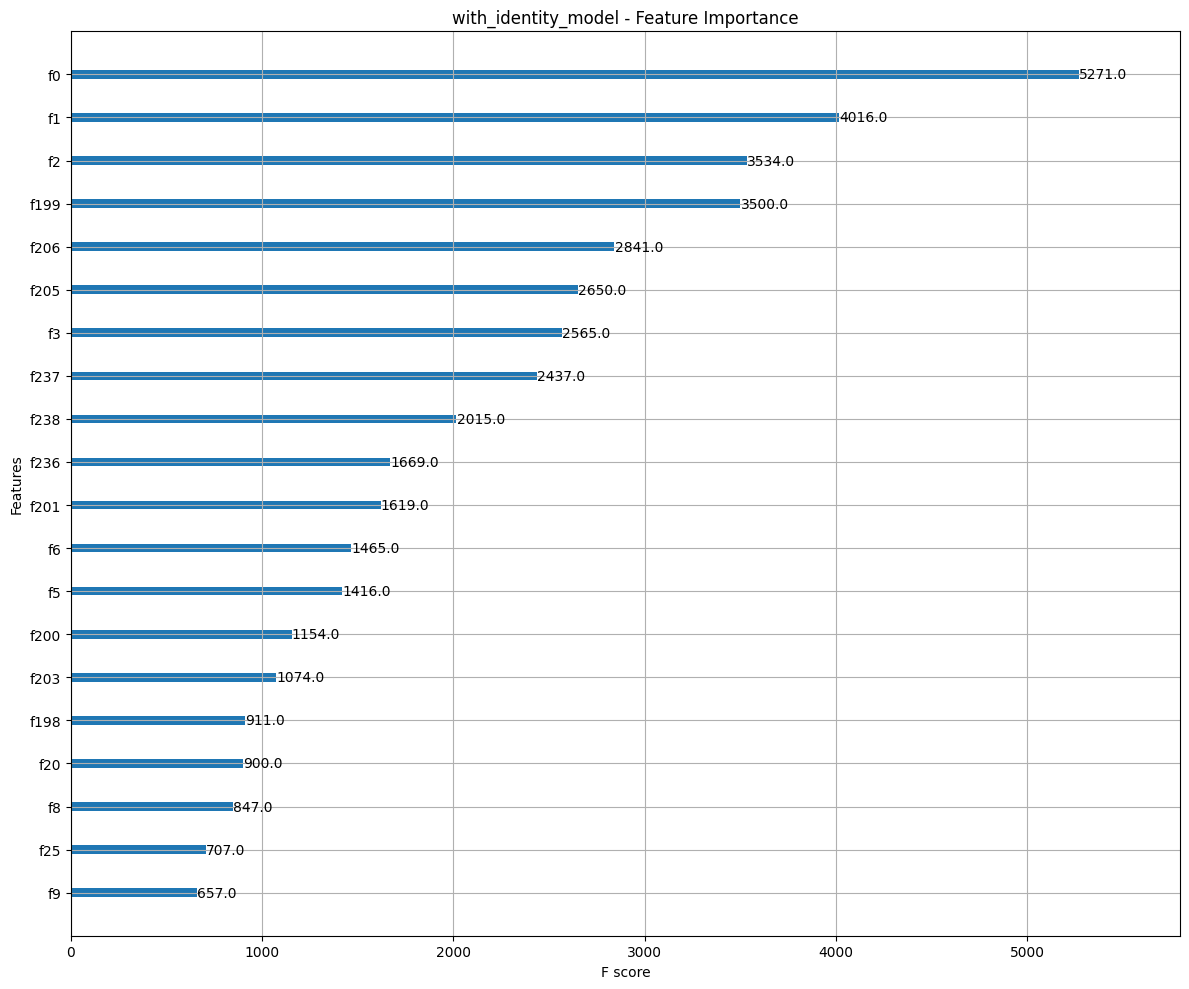

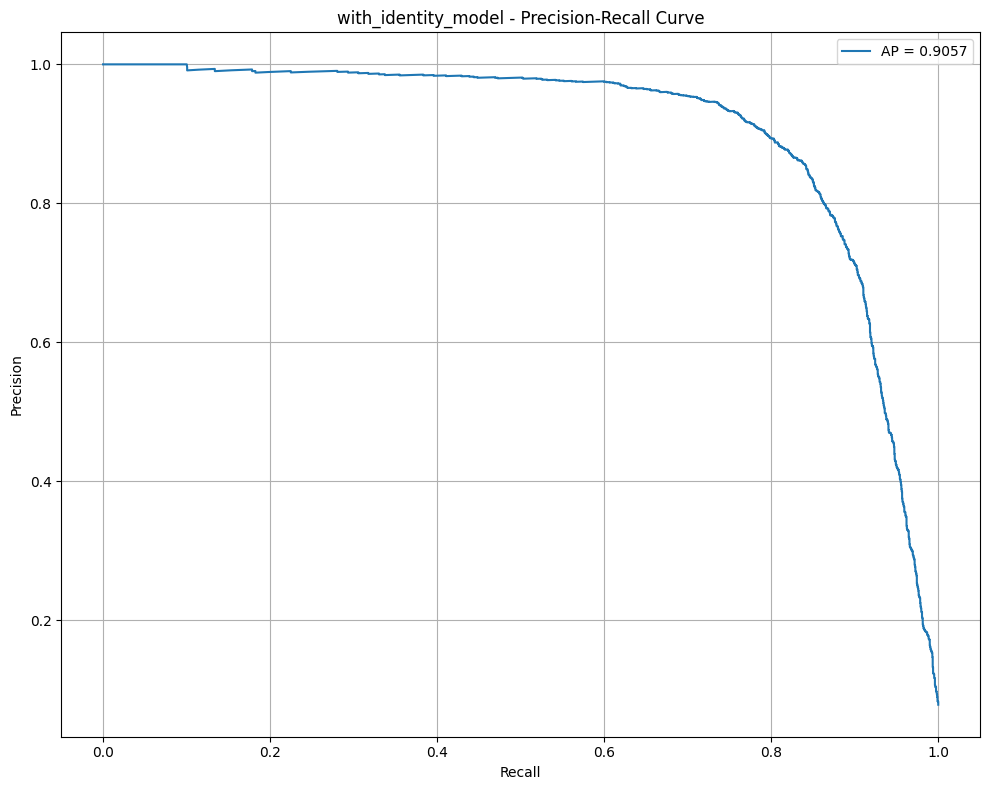

In [105]:
# Train model for WITH identity data

with_identity_model, with_identity_preds, with_identity_auc, with_identity_ap = train_and_evaluate_xgb(
    X_with_identity_train_processed, y_with_identity_train,
    X_with_identity_val_processed, y_with_identity_val,
    xgb_params.copy(), "with_identity_model"
)


Training without_identity_model model...
Class imbalance ratio (negative/positive): 46.76
Using scale_pos_weight: 46.76
[0]	train-auc:0.80851	val-auc:0.79527
[100]	train-auc:0.91298	val-auc:0.88447
[200]	train-auc:0.94252	val-auc:0.90621
[300]	train-auc:0.95867	val-auc:0.91731
[400]	train-auc:0.97017	val-auc:0.92554
[500]	train-auc:0.97689	val-auc:0.93067
[600]	train-auc:0.98186	val-auc:0.93504
[700]	train-auc:0.98560	val-auc:0.93841
[800]	train-auc:0.98884	val-auc:0.94118
[900]	train-auc:0.99115	val-auc:0.94356
[1000]	train-auc:0.99289	val-auc:0.94525
[1100]	train-auc:0.99424	val-auc:0.94654
[1200]	train-auc:0.99537	val-auc:0.94820
[1300]	train-auc:0.99625	val-auc:0.94900
[1400]	train-auc:0.99697	val-auc:0.94994
[1500]	train-auc:0.99752	val-auc:0.95082
[1600]	train-auc:0.99801	val-auc:0.95161
[1700]	train-auc:0.99839	val-auc:0.95241
[1800]	train-auc:0.99866	val-auc:0.95305
[1900]	train-auc:0.99891	val-auc:0.95359
[2000]	train-auc:0.99911	val-auc:0.95405
[2100]	train-auc:0.99926	val-a

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [11:09:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
2025/04/21 11:09:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


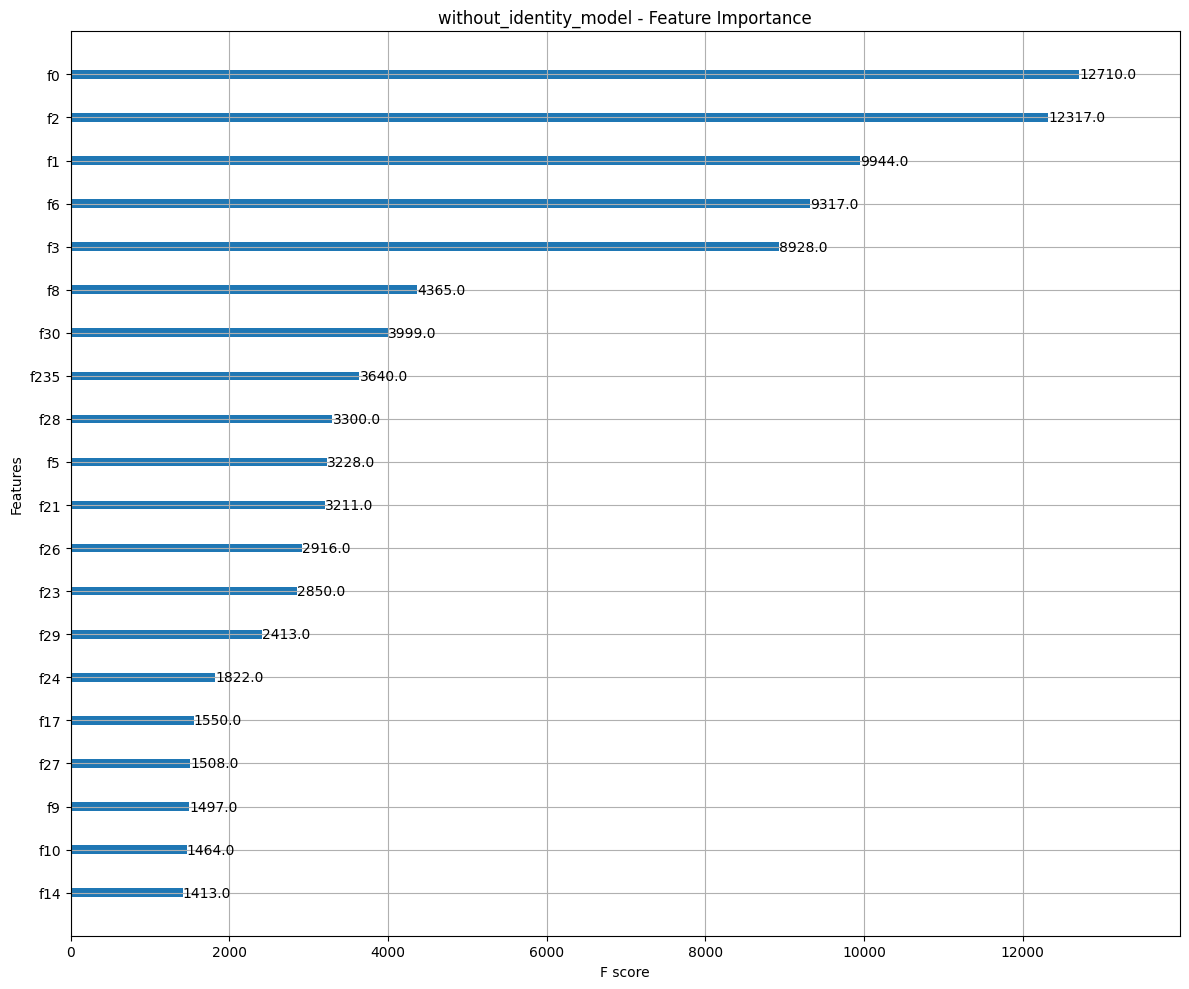

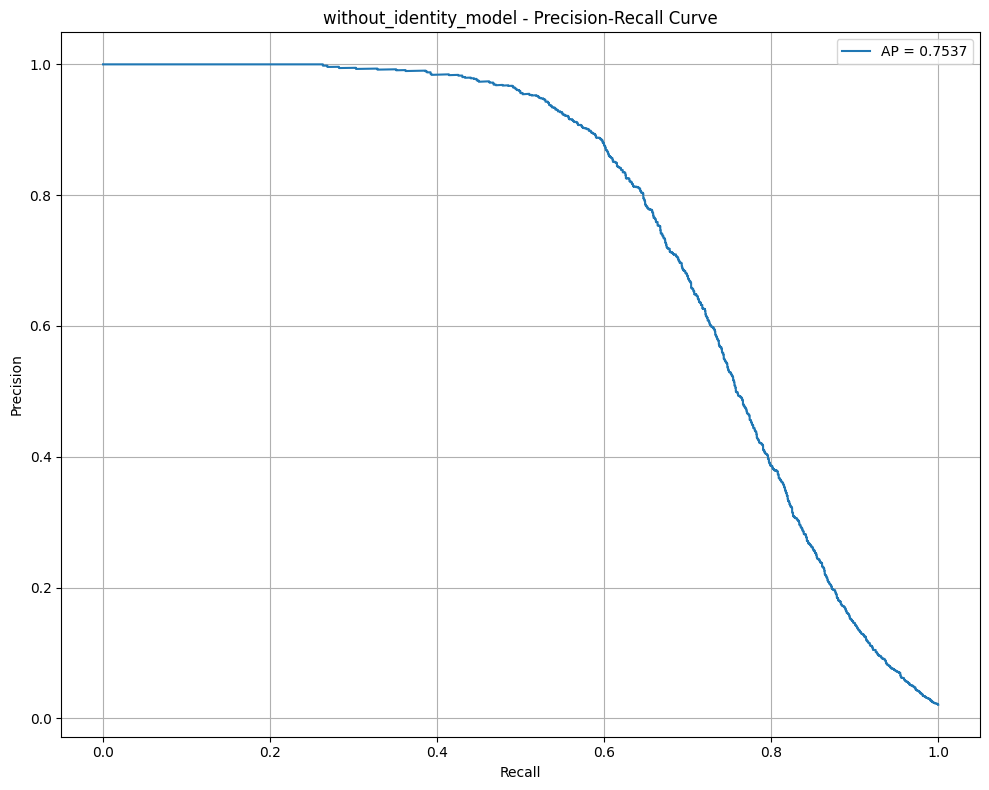

In [106]:
without_identity_model, without_identity_preds, without_identity_auc, without_identity_ap = train_and_evaluate_xgb(
    X_without_identity_train_processed, y_without_identity_train,
    X_without_identity_val_processed, y_without_identity_val,
    xgb_params.copy(), "without_identity_model"
)

In [107]:
print("\n--- Individual Model Comparison ---")
print(f"WITH identity model - Validation AUC: {with_identity_auc:.4f}, AP: {with_identity_ap:.4f}")
print(f"WITHOUT identity model - Validation AUC: {without_identity_auc:.4f}, AP: {without_identity_ap:.4f}")

if with_identity_auc > without_identity_auc:
    print("The WITH identity model performs better in terms of AUC.")
else:
    print("The WITHOUT identity model performs better in terms of AUC.")

if with_identity_ap > without_identity_ap:
    print("The WITH identity model performs better in terms of Average Precision.")
else:
    print("The WITHOUT identity model performs better in terms of Average Precision.")



--- Individual Model Comparison ---
WITH identity model - Validation AUC: 0.9788, AP: 0.9057
WITHOUT identity model - Validation AUC: 0.9572, AP: 0.7537
The WITH identity model performs better in terms of AUC.
The WITH identity model performs better in terms of Average Precision.


In [108]:
from sklearn.metrics import (roc_auc_score, precision_recall_curve, auc, 
                            average_precision_score, precision_score, 
                            recall_score, f1_score, confusion_matrix,
                            classification_report, roc_curve)

# Merge models

In [109]:
combined_val_preds = []
combined_val_true = []

# Add predictions from WITH identity model
combined_val_preds.extend(with_identity_preds)
combined_val_true.extend(y_with_identity_val)

# Add predictions from WITHOUT identity model
combined_val_preds.extend(without_identity_preds)
combined_val_true.extend(y_without_identity_val)

# Convert to numpy arrays
combined_val_preds = np.array(combined_val_preds)
combined_val_true = np.array(combined_val_true)

# Calculate metrics for different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_f1 = 0
best_threshold = 0.5

In [110]:
print("\nPerformance at different thresholds:")
print("Threshold | Precision | Recall | F1 Score | Accuracy")
print("----------|-----------|--------|----------|----------")

for threshold in thresholds:
    # Convert probabilities to binary predictions
    combined_val_pred_binary = (combined_val_preds >= threshold).astype(int)
    
    # Calculate metrics
    precision = precision_score(combined_val_true, combined_val_pred_binary)
    recall = recall_score(combined_val_true, combined_val_pred_binary)
    f1 = f1_score(combined_val_true, combined_val_pred_binary)
    accuracy = (combined_val_pred_binary == combined_val_true).mean()
    
    print(f"{threshold:.1f}       | {precision:.4f}    | {recall:.4f} | {f1:.4f}   | {accuracy:.4f}")
    
    # Track best F1 score
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold


Performance at different thresholds:
Threshold | Precision | Recall | F1 Score | Accuracy
----------|-----------|--------|----------|----------
0.1       | 0.2520    | 0.9245 | 0.3960   | 0.9013
0.2       | 0.3858    | 0.8897 | 0.5382   | 0.9466
0.3       | 0.4981    | 0.8640 | 0.6319   | 0.9648
0.4       | 0.6028    | 0.8374 | 0.7010   | 0.9750
0.5       | 0.6905    | 0.8103 | 0.7456   | 0.9807
0.6       | 0.7671    | 0.7796 | 0.7733   | 0.9840
0.7       | 0.8352    | 0.7457 | 0.7879   | 0.9860
0.8       | 0.8950    | 0.7012 | 0.7863   | 0.9867
0.9       | 0.9527    | 0.6240 | 0.7541   | 0.9858


In [111]:
print(f"\nBest threshold based on F1 score: {best_threshold:.2f}")
combined_val_pred_binary = (combined_val_preds >= best_threshold).astype(int)

# Calculate comprehensive metrics
combined_precision = precision_score(combined_val_true, combined_val_pred_binary)
combined_recall = recall_score(combined_val_true, combined_val_pred_binary)
combined_f1 = f1_score(combined_val_true, combined_val_pred_binary)
combined_auc = roc_auc_score(combined_val_true, combined_val_preds)
combined_ap = average_precision_score(combined_val_true, combined_val_preds)

# Print comprehensive results
print("\n--- Combined Model Performance (at optimal threshold) ---")
print(f"Precision: {combined_precision:.4f}")
print(f"Recall: {combined_recall:.4f}")
print(f"F1 Score: {combined_f1:.4f}")
print(f"ROC AUC: {combined_auc:.4f}")
print(f"Average Precision: {combined_ap:.4f}")


Best threshold based on F1 score: 0.70

--- Combined Model Performance (at optimal threshold) ---
Precision: 0.8352
Recall: 0.7457
F1 Score: 0.7879
ROC AUC: 0.9701
Average Precision: 0.8399


In [112]:
cm = confusion_matrix(combined_val_true, combined_val_pred_binary)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Calculate additional metrics
specificity = tn / (tn + fp)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"\nSpecificity: {specificity:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")


Confusion Matrix:
True Negatives: 113368
False Positives: 608
False Negatives: 1051
True Positives: 3082

Specificity: 0.9947
Negative Predictive Value: 0.9908


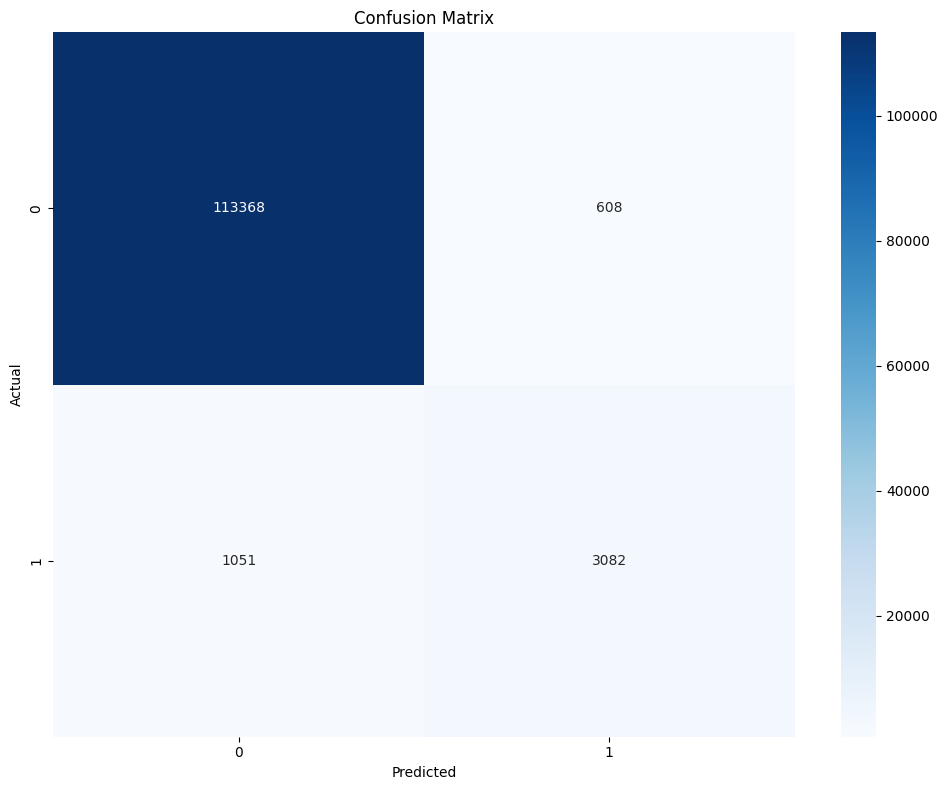

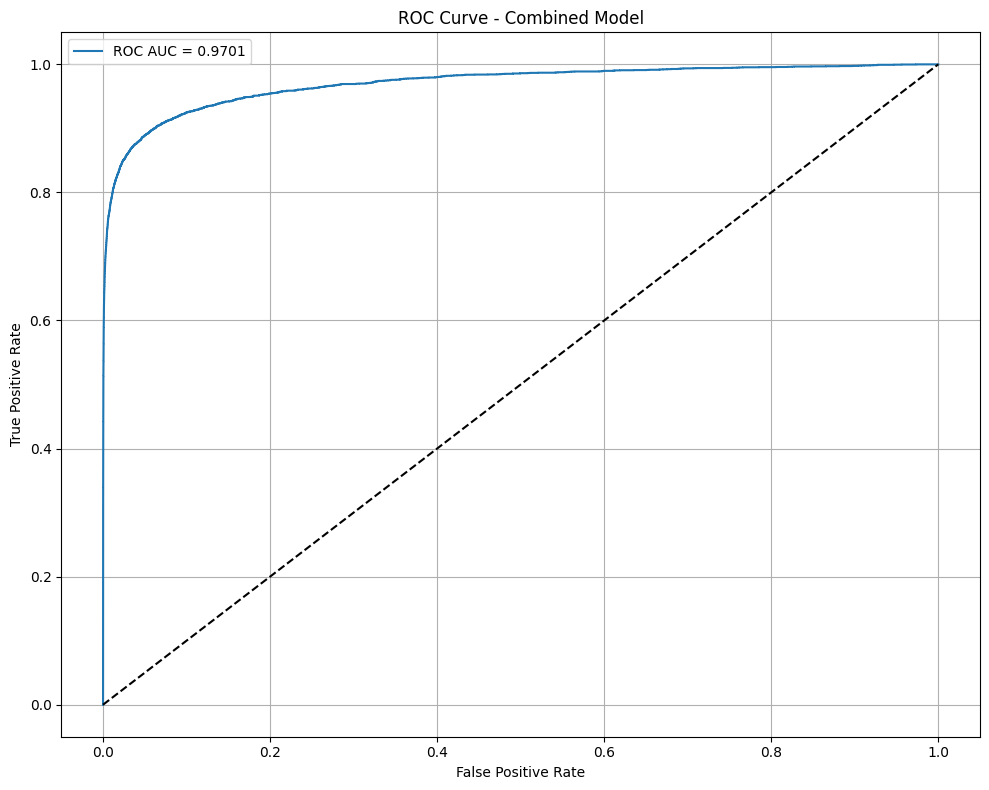

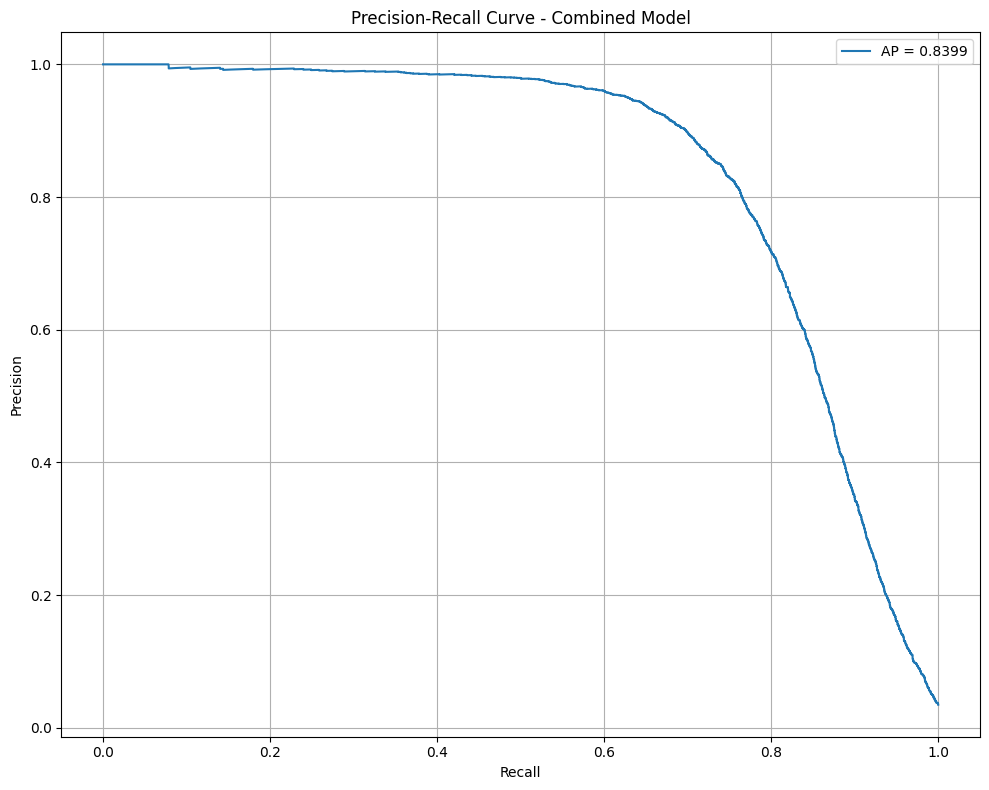

In [113]:
if mlflow_active:
    mlflow.log_metric("combined_precision", combined_precision)
    mlflow.log_metric("combined_recall", combined_recall)
    mlflow.log_metric("combined_f1", combined_f1)
    mlflow.log_metric("combined_auc", combined_auc)
    mlflow.log_metric("combined_ap", combined_ap)
    mlflow.log_metric("best_threshold", best_threshold)
    
    # Log confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')
    plt.tight_layout()
    cm_path = "combined_confusion_matrix.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    
    # Log ROC curve
    fpr, tpr, _ = roc_curve(combined_val_true, combined_val_preds)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(fpr, tpr, label=f'ROC AUC = {combined_auc:.4f}')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve - Combined Model')
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    roc_path = "combined_roc_curve.png"
    plt.savefig(roc_path)
    mlflow.log_artifact(roc_path)
    
    # Log precision-recall curve
    precision, recall, _ = precision_recall_curve(combined_val_true, combined_val_preds)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(recall, precision, label=f'AP = {combined_ap:.4f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve - Combined Model')
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    pr_path = "combined_pr_curve.png"
    plt.savefig(pr_path)
    mlflow.log_artifact(pr_path)

In [114]:
print("\nClassification Report:")
print(classification_report(combined_val_true, combined_val_pred_binary))



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    113976
           1       0.84      0.75      0.79      4133

    accuracy                           0.99    118109
   macro avg       0.91      0.87      0.89    118109
weighted avg       0.99      0.99      0.99    118109



In [115]:
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

if mlflow_active:
    mlflow.log_metric("total_execution_time", execution_time)
    mlflow.end_run()
    print("MLflow run completed successfully.")


Total execution time: 3648.75 seconds
🏃 View run xgboost_preprocessing_20250421_101352 at: https://dagshub.com/konstantine25b/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/10/runs/e75d3cbbcd19426cbe1403e0816c2a80
🧪 View experiment at: https://dagshub.com/konstantine25b/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/10
MLflow run completed successfully.
